<a href="https://colab.research.google.com/github/Fujnaa/PPPOProjekat/blob/main/PPPO_Vuk_Stoji%C4%87_IT51_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikacija Rasa Pasa**

Tema ovog projekta jeste kreiranje modela koji će biti sposoban da samostalno identifikuje različite rase pasa. Ovakav model mogao bi imati široku primenu u mnogim domaćinstvima a utoliko i u veterinarskim službama.

Naime, cilj ovog projekta jeste razvijanje modela koji će efikasno vršiti klasifikaciju rasa psa, koristeći dostupne podatke za treniranje pomenutog modela. Odabrana tehnologija koja će omogućiti pomenuto jeste Deep Learning (Duboko učenje) putem konvolutivnih neuronskih mreža (CNN).

# Klasifikacija

Klasifikacija predstavlja proces grupisanja podataka u određene kategorije (klase) koristiće određene karakteristike podataka ili njihove atribute.

U računarstvu, klasifikacija je važan zadatak mašinskog učenja i veštačke inteligencije. Ona se koristi za svakojake svrhe, uključujući prepoznavanje oblika, prepoznavanje lica, filtriranje spam poruka, itd. Time jasno je da je ovo pogodna tehnologija za ovaj projekat.

Klasifikacija se obično izvodi pomoću algoritama mašinskog učenja koji analiziraju karakteristike ulaznih podataka i zatim ih kategorizuju u određene klase na osnovu prethodno naučenih modela ili uzorka. Uobičajeni pristupi uključuju algoritme kao što su logistička regresija, k-susedi, drveće odlučivanja, veštačke neuronske mreže i mnogi drugi.

Kao što je ranije napomenuto, u svrhe ovog projekta koristiće se konvolutivne neuronske mreže.

# Konvolutivne Neuronske Mreže (CNN)


Konvolutivne neuronske mreže, ili Convolutional Neural Networks (CNN) su vrsta neuronskih mreža koje su posebno dizajnirane za obradu i analizu vizuelnih podataka poput slika. Zbog svoje sposobnosti automatskog izvlačenja konteksta i značenja iz slika, ova tehnologija je postala ključni alat u oblasti računarske vizije i mašinskog učenja.

Interesantno je to što se kroz proces treniranja CNN-ovi prilagođavaju specifičnom zadatku klasifikacije slika. To je moguće automatskim učenjem optimalnih parametara koji su potrebni za efikasno izvršavanje zadatka.

CNN je pogodan za ovaj projekat zbog efikasnosti obrade slika, aritekture prilagođene prostornim strukturama (slojevi konvolutivnih filtera, o njima reči kasnije) i dostupnosti prethodno obučenih modela koji će nam biti potrebni za zaključno poređenje.

# Kako rade CNN?

Centralni element u funkcionisanju CNN-a je konvolucija. Konvolucioni slojevi koriste niz filtera koji prelaze preko ulazne slike, izdvajajući karakteristike poput ivica, tekstura ili oblika. Tokom ovog procesa, svaki filter detektuje određeni uzorak na različitim delovima slike, generišući mapu karakteristika kao rezultat.

Važno je napomenuti da nakon svake konvolucione operacije, primenjujemo nelinearnost na izlaze koristeći aktivacione funkcije poput ReLU (Rectified Linear Unit), što omogućava modelu da nauči složenije obrasce i veze između piksela slike.

Pored konvolucionih slojeva, CNN sadrži i slojeve agregacije. Ovi slojevi služe za smanjenje dimenzionalnosti mape karakteristika i izdvajanje najvažnijih informacija, obično korišćenjem tehnika poput maksimalnog ili prosečnog uzorkovanja.

Nakon serije konvolucionih i slojeva agregacije, podaci se prosleđuju kroz potpuno povezane slojeve. Ovi slojevi funkcionišu kao tradicionalni neuronski slojevi, gde su svi neuroni povezani sa svim neuronima prethodnog sloja. Potpuno povezani slojevi često se koriste za klasifikaciju ili regresiju.

Kao poslednji korak u procesu, CNN obično završava sa Softmax slojem. Ovaj sloj transformiše izlazne vrednosti CNN-a u vektor verovatnoća za svaku moguću klasu, omogućavajući procenu verovatnoće da ulazna slika pripada svakoj od klasa.

# Importovanje odgovarajućih Biblioteka

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
from tensorflow.keras import layers, models
tf.disable_v2_behavior()
import numpy as np
import pandas as pd

import time
from datetime import timedelta

import math
import os

import scipy.misc
from random import sample
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Biblioteka za manipulaciju slikama
import PIL.Image
from PIL import Image
from IPython.display import display

# Biblioteka za manipulaciju ZIP fajlova
from zipfile import ZipFile
from io import BytesIO

# Povezivanje sa drajvom i pronalazak podataka

In [12]:
# Povezivanje Google Drive-a, gde će se nalaziti dataset
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/PPPO/

#Otvaranje dataseta
zip_path = ZipFile('/content/drive/MyDrive/PPPO/data.zip', 'r')
len(zip_path.namelist()[:]) - 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PPPO


757

# Normalizovanje Podataka

U okviru sledeće ćelije prolazimo kroz sve slike u folderima, i menjamo veličinu slika u 244x244, i normalizujemo piksele slika deljenjem sa 255, kako bismo dobili piksele vrednosti u opsegu [0,1]. Piksele normaliyujemo jer to doprinosi numeričkoj stabilnosti, konzistentnoj interpretaciji podataka, bržem učenju i efikasnijoj optimizaciji modela.

Nakon ovoga, u niz labels se ubacuju odgovarajuće labele svake pojedinačne slike kako bismo znali u koju klasu potpada koja slika. Takodje, imamo promenljivu vrednost dimenzija slika nad kojom je izvršeno samo poredjenje izmedju rezultata od dimenzija slika 120x120 i 224x224 (više o tome kasnije).

In [13]:
def normalize_images_from_zip(zip_path, folders):
    normalized_images = []
    labels = []  # Lista za čuvanje oznaka klasa
    with zip_path as zip_ref:
        for label, folder in enumerate(folders):
            print(str(label) + ' = ' + folder[5:])
            file_list = zip_ref.namelist()
            for file in file_list:
                if file.startswith(folder) and file.endswith('.jpg'):  # Prolazak samo kroz slike unutar određenog foldera
                    with zip_ref.open(file) as img_file:  # Ovde koristimo .open() metodu za čitanje sadržaja fajla unutar zip-a
                        img = Image.open(img_file)
                        img = img.resize((image_width, image_height))  # Prilagodite veličinu slike prema vašim potrebama
                        img_array = np.array(img)
                        normalized_img = img_array / 255.0  # Normalizacija piksela na opseg [0, 1]
                        normalized_images.append(normalized_img)
                        labels.append(label)  # Dodavanje oznake klase
    return normalized_images, labels  # Vraćanje i normalizovanih slika i oznaka klasa

# Folderi koji sadrže slike koje treba normalizovati
folders = ["data/Bedlington_terrier", "data/Bernese_mountain_dog", "data/Dandie_Dinmont", "data/Gordon_setter", "data/Ibizan_hound", "data/Norwegian_elkhound"]

# Željene dimenzije slike nakon normalizacije
image_width = 120
image_height = 120

# Normalizacija slika
normalized_images, labels = normalize_images_from_zip(zip_path, folders)

# Čuvanje normalizovanih slika koristeći pickle
with open('normalized_images.pkl', 'wb') as f:
    pickle.dump(normalized_images, f)

print("Number of normalized images:", len(normalized_images))

0 = Bedlington_terrier
1 = Bernese_mountain_dog
2 = Dandie_Dinmont
3 = Gordon_setter
4 = Ibizan_hound
5 = Norwegian_elkhound
Number of normalized images: 752


# Prikaz jednog primera normalizovane slike:

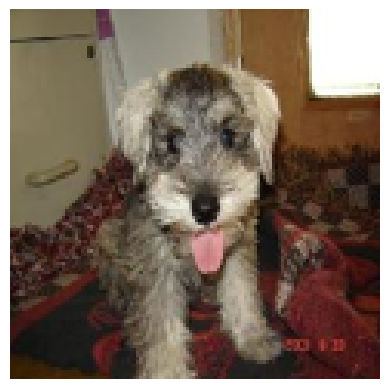

In [14]:
#Prikazivanje jedne normalizovane slike
plt.imshow(normalized_images[0])
plt.axis('off')  # Isključivanje oznaka osa
plt.show()

# Deljenje podataka za treniranje i testiranje

Sa obzirom da dati data set ne sadrži razdvojene podatke isključivo za treniranje i isključivo za testiranje, potrebno je da naše podatke samostalno podelimo. Naime, podela je izvršena u opsegu 80% podataka za treniranje i 20% podataka za testiranje. U jednom momentu je testiran opseg 90:10, ali nije pravilo značajne razlike pa je vraćen na standardni opseg 80:20.

In [15]:

# Podela podataka na skupove za obuku i testiranje
train_images, test_images, train_labels, test_labels = train_test_split(normalized_images, labels, test_size=0.2, stratify=labels)



# Provera balansa klasa u skupu za obuku
train_class_distribution = {folder[5:]: train_labels.count(label) for label, folder in enumerate(folders)}
print("Balans klasa u skupu za obuku:", train_class_distribution)

# Provera balansa klasa u skupu za testiranje
test_class_distribution = {folder[5:]: test_labels.count(label) for label, folder in enumerate(folders)}
print("Balans klasa u skupu za testiranje:", test_class_distribution)

Balans klasa u skupu za obuku: {'Bedlington_terrier': 108, 'Bernese_mountain_dog': 105, 'Dandie_Dinmont': 92, 'Gordon_setter': 93, 'Ibizan_hound': 99, 'Norwegian_elkhound': 104}
Balans klasa u skupu za testiranje: {'Bedlington_terrier': 28, 'Bernese_mountain_dog': 26, 'Dandie_Dinmont': 23, 'Gordon_setter': 23, 'Ibizan_hound': 25, 'Norwegian_elkhound': 26}


# Definisanje, Treniranje i Evaluacija Modela

Konačno, sledi rad na samom modelu.
Prvo je kreiran niz slika koji je u odgovarajućim dimenzijama koja neuronska mreža očekuje.

Nadalje, definisana je arhitektura neuronske mreže koristeći "Sequential" model iz Keras biblioteke. Ova mreža sadrži slojeve za konvolutivnu obradu slika (Conv2D), slojeve za agregaciju podataka (MaxPooling2D), sloj za ravnjanje podataka (Flatten) i dva potpuno povezana sloja (Dense). Aktivaciona funkcija 'relu' se koristi u konvolutivnim slojevima i prvom potpuno povezanom sloju, dok se za izlazni sloj koristi 'softmax' aktivaciona funkcija zbog klasifikacije.

*Konvolutivni sloj* (Conv2D): Ovaj sloj koristi niz filtriranja (ili filtera) kako bi obrađivao ulazne slike. Filteri prolaze kroz sliku korak po korak (korak filtriranja), primenjujući operaciju konvolucije na male podskupove slike. Ovo omogućava sloju da detektuje različite karakteristike slike poput ivica, tekstura ili oblika. Aktivacija ReLU (Rectified Linear Unit) primenjuje se nakon konvolucije kako bi se uklonile negativne vrednosti i dodala nelinearnost u model.

*Sloj agregacije* (MaxPooling2D): Ovi slojevi služe za smanjenje dimenzionalnosti ulaznih podataka tako što zadržavaju samo najvažnije informacije. Konkretno, Max Pooling vrši uzimanje maksimalne vrednosti iz malih podskupova slike. To omogućava modelu da bude manje osetljiv na male translacije objekata u slici, a istovremeno smanjuje broj parametara i računarskih operacija potrebnih za treniranje modela.

Sloj ravnanja (Flatten): Nakon poslednjeg sloja agregacije, ulazni podaci se ravnomerno raspoređuju u jednodimenzioni vektor kako bi se prešlo sa konvolucione faze na potpuno povezane slojeve.

Dropout sloj (Dropout): Ovaj sloj dodaje regularizaciju u model. Dropout slučajno "isključuje" određeni procenat neurona tokom treninga, čime se sprečava preprilagođavanje (overfitting) i poboljšava generalizacija modela.

*Potpuno povezani sloj* (Dense): Ovi slojevi povezuju sve neurone iz prethodnog sloja sa svakim neuronom u trenutnom sloju. Oni služe za stvaranje konačnog izlaza modela. Na kraju, softmax aktivaciona funkcija koristi se na poslednjem potpuno povezanom sloju kako bi se generisale verovatnoće pripadnosti ulaznih podataka određenim klasama, što omogućava modelu da izvrši klasifikaciju.

In [31]:

# Broj primera za obuku i testiranje
num_train_examples = len(train_images)
num_test_examples = len(test_images)

# Kreiranje nizova slika sa tačno određenim brojem primera
train_images = np.array(train_images).reshape((num_train_examples, image_width, image_height, 3))
test_images = np.array(test_images).reshape((num_test_examples, image_width, image_height, 3))

# Definisanje arhitekture modela
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Dodavanje dropout sloja radi regularizacije
    layers.Dense(512, activation='relu'),
    layers.Dense(len(folders), activation='softmax')  # Broj izlaznih neurona odgovara broju klasa
])

# Kompajliranje modela
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Treniranje modela
history = model.fit(train_images, train_labels, epochs=15, validation_data=(test_images, test_labels))

# Evaluacija modela
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test tačnost:', str(test_acc * 100) + '%')

Train on 601 samples, validate on 151 samples
Epoch 1/15
601/601 [==============================] - ETA: 0s - loss: 1.7903 - acc: 0.2030

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


601/601 [==============================] - 21s 35ms/sample - loss: 1.7903 - acc: 0.2030 - val_loss: 1.7607 - val_acc: 0.1722
Epoch 2/15
601/601 [==============================] - 20s 33ms/sample - loss: 1.6196 - acc: 0.2829 - val_loss: 1.5063 - val_acc: 0.3775
Epoch 3/15
601/601 [==============================] - 17s 29ms/sample - loss: 1.4284 - acc: 0.3810 - val_loss: 1.4211 - val_acc: 0.4106
Epoch 4/15
601/601 [==============================] - 19s 31ms/sample - loss: 1.2617 - acc: 0.4576 - val_loss: 1.4292 - val_acc: 0.3974
Epoch 5/15
601/601 [==============================] - 22s 36ms/sample - loss: 1.2166 - acc: 0.4892 - val_loss: 1.3678 - val_acc: 0.3974
Epoch 6/15
601/601 [==============================] - 19s 32ms/sample - loss: 1.1119 - acc: 0.5374 - val_loss: 1.4324 - val_acc: 0.4040
Epoch 7/15
601/601 [==============================] - 19s 31ms/sample - loss: 1.0340 - acc: 0.5807 - val_loss: 1.2757 - val_acc: 0.4570
Epoch 8/15
601/601 [==============================] - 18s 3

# Rezultati

Nakon dugotrajnog testiranja, menjanja arhitekture, dobijen je rezultat od 56% tačnosti.

# Test 1

Početna arhitektura modela prikazana je na slici u nastavku, naime možemo reći da se znatno razlikuje od finalne arhitekture modela. Takodje, tada se treniranje modela izvršavalo kroz 10 epoha. Prvi test davao je rezultate od 45%.

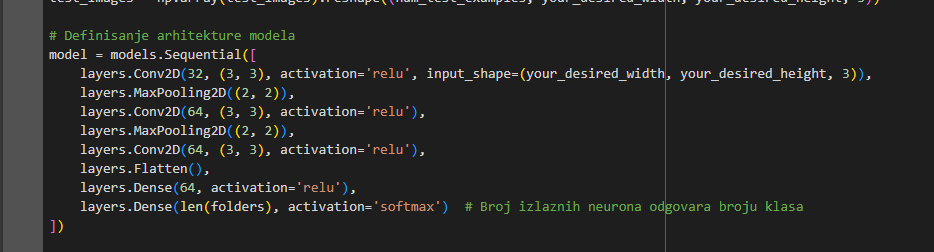

#Test 2

Nakon ovoga testirano je povećanje broja filtera na prvom konvolutivnog sloju na 64, i na drugom na 124. Ovo je poboljšalo model na 51% preciznosti.


#Test 3

U trećem testu dodat je još jedan konvolutivni sloj od 64 filtera. Ovo je pogoršalo preciznost modela na 47%, pa je dodat sloj momentalno uklonjen.

#Test 4

U okviru četvrtog testa povećana je rezolucija slika na 244x244, što je, iznenadjujuće, pogoršalo model. Ova rezolucija slika je ostavljena za sada za dalje testiranje, zbog neobičnosti svojih rezultata smatra se da je problem u arhitekturi modela. Rezultat je bio 48% preciznosti.

#Test 5

Povećan je broj podataka koji se koristi za treniranje, postavljeno da se 90% podataka iz data set-a koristi za treniranje, a samo 10% za testiranje. Rezultat ovoga je bila preciznost od 47%, iz ovog razloga je ova promena obustavljena.

#Test 6

Promenjena je aktivacija koja se koristi nakon potpuno povezanog sloja iz "ReLu" u "Softmax", što je drastično smanjilo preciznost modela, čak na 18%.
Nakon ovoga testirana je još jedna, aktivacija, konkretno "sigmoid", koja je dala još gore rezultate (17%). Naravno, nakon ovoga je aktivacija samo vraćena na Relu.

#Test 7

Napokon je vraćena dimenzija slika na 122x122, što je vratilo preciznost na 49%

#Test 8

Arhitektura modela je znatno promenjena, što je dovelo do povećanja preciznosti na 51%.

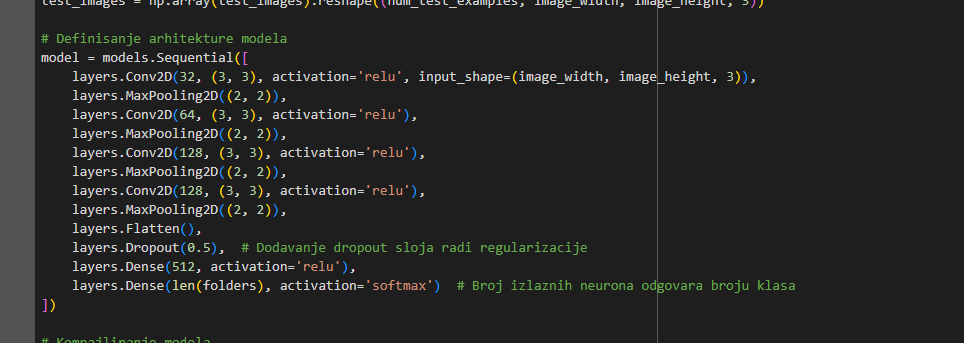

#Finalni Test

Konačno, povećan je broj epoha za treniranje modela na 15, što je dovelo do preciznosti modela od 58%.

# Poredjenje rezultata sa stvarnim vrednostima

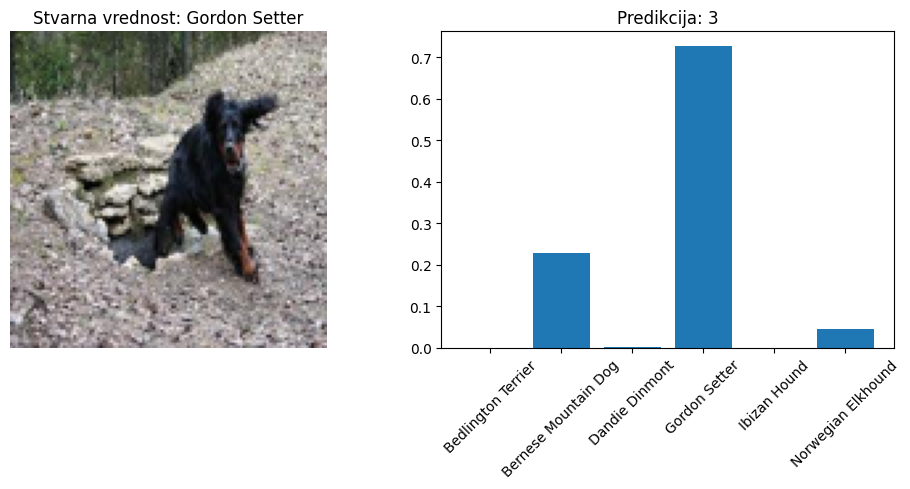

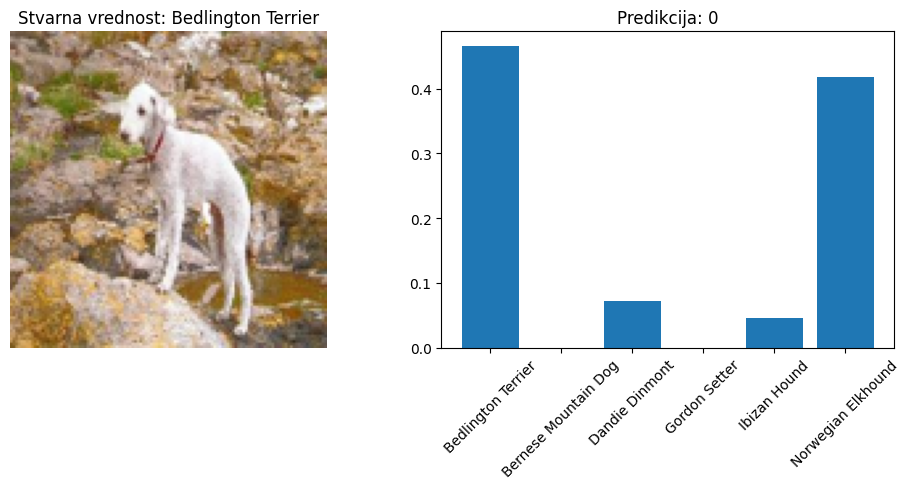

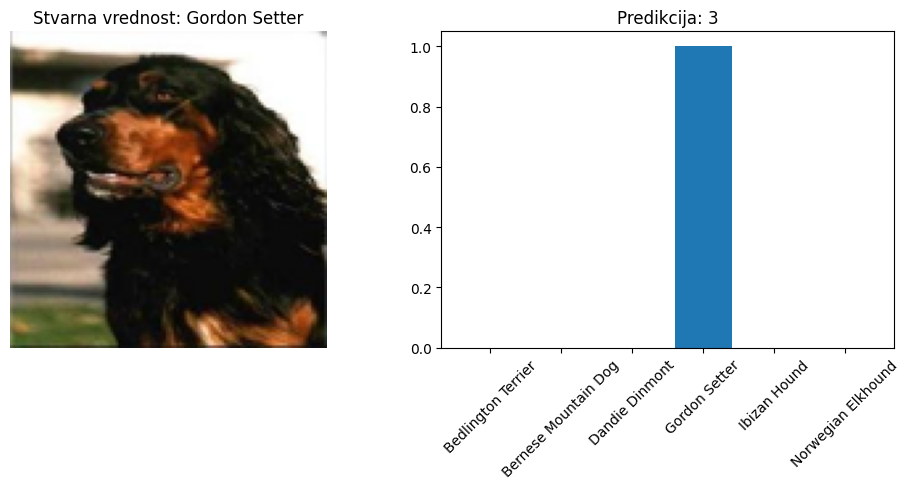

In [32]:
# Izaberite nekoliko primera koje želite da uporedite
num_examples_to_compare = 3
examples_to_compare = np.random.choice(len(test_images), num_examples_to_compare)

# Dobijanje predikcija modela za izabrane primere
predictions = model.predict(test_images[examples_to_compare])

# Vizuelno upoređivanje stvarnih vrednosti i predikcija
for i, example_index in enumerate(examples_to_compare):
    plt.figure(figsize=(10, 5))

    # Prikaz slike
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[example_index])
    plt.title("Stvarna vrednost: {}".format(classes[test_labels[example_index]]))
    plt.axis('off')

    classes = ["Bedlington Terrier", "Bernese Mountain Dog", "Dandie Dinmont", "Gordon Setter", "Ibizan Hound", "Norwegian Elkhound"]

    # Prikaz predikcije
    plt.subplot(1, 2, 2)
    plt.bar(range(len(folders)), predictions[i])
    plt.title("Predikcija: {}".format(np.argmax(predictions[i])))
    plt.xticks(range(len(folders)), classes, rotation=45)
    plt.tight_layout()

    plt.show()

# Poredjenje sa unapred istreniranim modelom

Sada kada smo videli rezultate samostalno razvijenog CNN modela, hajde da ga uporedimo sa modelom koji je itreniran sa mnogo većom količinom podataka.

In [28]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers

# Kreiranje nizova slika sa tačno određenim brojem primera
train_images = np.array(train_images).reshape((num_train_examples, image_width, image_height, 3))
test_images = np.array(test_images).reshape((num_test_examples, image_width, image_height, 3))

# Učitavanje prethodno istreniranog modela ResNet50 sa ImageNet težinama
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# Odmrzavanje nekoliko slojeva za fino podešavanje (fine-tuning)
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Dodavanje dodatnih slojeva na ResNet50 model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Dodajemo dropout sloj radi regularizacije
    layers.Dense(256, activation='relu'),
    layers.Dense(len(folders), activation='softmax')
])

#Kompajliranje modela
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Treniranje modela
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Evaluacija modela
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test tačnost:', str(test_acc * 100) + '%')

Train on 601 samples, validate on 151 samples
Epoch 1/10
601/601 [==============================] - ETA: 0s - loss: 0.9318 - acc: 0.6922

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


601/601 [==============================] - 50s 83ms/sample - loss: 0.9318 - acc: 0.6922 - val_loss: 4.5639 - val_acc: 0.1457
Epoch 2/10
601/601 [==============================] - 48s 80ms/sample - loss: 0.1808 - acc: 0.9501 - val_loss: 2.5532 - val_acc: 0.1722
Epoch 3/10
601/601 [==============================] - 47s 78ms/sample - loss: 0.0647 - acc: 0.9800 - val_loss: 2.0368 - val_acc: 0.1722
Epoch 4/10
601/601 [==============================] - 55s 92ms/sample - loss: 0.0695 - acc: 0.9800 - val_loss: 2.0128 - val_acc: 0.1722
Epoch 5/10
601/601 [==============================] - 51s 84ms/sample - loss: 0.0424 - acc: 0.9884 - val_loss: 2.0640 - val_acc: 0.1722
Epoch 6/10
601/601 [==============================] - 56s 92ms/sample - loss: 0.0237 - acc: 0.9950 - val_loss: 2.0969 - val_acc: 0.1722
Epoch 7/10
601/601 [==============================] - 51s 86ms/sample - loss: 0.0515 - acc: 0.9884 - val_loss: 2.0402 - val_acc: 0.1722
Epoch 8/10
601/601 [==============================] - 51s 8

Inicijalnim testom sa pretrained modelom, dobili smo, što je iznenadjujuće, lošije rezultate. Sa tačnosti od 17%. Korišćena arhitektura pronadjena je iz eksternog izvora, gde je drugi tester koristio ovu arhitekturu i dobio rezultate od 71% za klasifikaciju rasa pasa. Medjutim, iz nekog razloga ovo ne odgovara našem setu podataka.

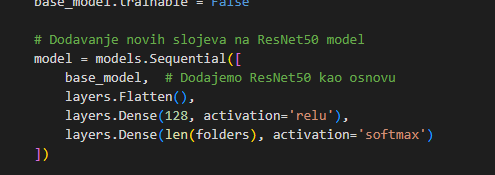

#Promena u arhitekturi

Arhitektura je znatno promenjena u nadi za poboljšanjem preciznosti eksternog modela, medjutim, nema velike promene u preciznosti. Pomenuta arhitektura je trenutno aktivna arhitektura.